In [1]:
# basics
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

import pickle 

# Keras Libraries
import keras
import tensorflow as tf
from keras import backend as K
from keras import metrics
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.metrics import AUC
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import keras.backend

In [2]:
# Set a seed value
seed_value= 42

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)

# 5. For layers that introduce randomness like dropout, make sure to set seed values 
#model.add(Dropout(0.25, seed=seed_value))

In [3]:
project_path = "/Users/freazx/Documents/ONE TAB/CODING"
train_path = project_path + "/chest_xray/setB/train/"
val_path = project_path + "/chest_xray/setB/val/"
test_path = project_path + "/chest_xray/setB/test/"

In [4]:
hyper_dimension = 64
hyper_batch_size = 32
hyper_epochs = 100

## Training in grayscale instead of RGB
hyper_channels = 1
hyper_mode = 'grayscale'

In [5]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0, 
                                   shear_range = 0.2,
                                   zoom_range = 0.2, 
                                   horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale=1.0/255.0) 
test_datagen = ImageDataGenerator(rescale=1.0/255.0) 

train_generator = train_datagen.flow_from_directory(directory = train_path, 
                                                    target_size = (hyper_dimension, hyper_dimension),
                                                    batch_size = hyper_batch_size, 
                                                    color_mode = hyper_mode,
                                                    class_mode = 'binary', 
                                                    seed = 42)
val_generator = val_datagen.flow_from_directory(directory = val_path, 
                                                 target_size = (hyper_dimension, hyper_dimension),
                                                 batch_size = hyper_batch_size, 
                                                 class_mode = 'binary',
                                                 color_mode = hyper_mode,
                                                 shuffle=False,
                                                 seed = 42)
test_generator = test_datagen.flow_from_directory(directory = test_path, 
                                                 target_size = (hyper_dimension, hyper_dimension),
                                                 batch_size = hyper_batch_size, 
                                                 class_mode = 'binary',
                                                 color_mode = hyper_mode,
                                                 shuffle=False,
                                                 seed = 42)

test_generator.reset()

Found 4104 images belonging to 2 classes.
Found 871 images belonging to 2 classes.
Found 876 images belonging to 2 classes.


In [6]:
def create_charts(cnn, cnn_model):
    ## Define train & validation loss
    train_loss = cnn_model.history['loss']
    val_loss = cnn_model.history['val_loss']
    
    ## Define train & validation AUC
    train_auc_name = list(cnn_model.history.keys())[3]
    val_auc_name = list(cnn_model.history.keys())[1]
    train_auc = cnn_model.history[train_auc_name]
    val_auc = cnn_model.history[val_auc_name]
    
    ## Define y_pred & y_true
    y_true = test_generator.classes
    Y_pred = cnn.predict(test_generator, steps=len(test_generator))
    y_pred = (Y_pred > 0.5).T[0]
    y_pred_prob = Y_pred.T[0]
    
    ## PLOT ##
    fig = plt.figure(figsize=(13, 10))
    
    ## PLOT 1: TRAIN VS. VALIDATION LOSS 
    plt.subplot(2,2,1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    ## PLOT 2: TRAIN VS. VALIDATION AUC
    plt.subplot(2,2,2)
    plt.title("Training vs. Validation AUC Score")
    plt.plot(train_auc, label='training auc')
    plt.plot(val_auc, label='validation auc')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()
    
    ## PLOT 3: CONFUSION MATRIX
    plt.subplot(2,2,3)
    # Set up the labels for in the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    names = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ticklabels = ['Normal', 'Pneumonia']

    # Create confusion matrix as heatmap
    sns.set(font_scale = 1.4)
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels )
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Confusion Matrix") #plt.title("Confusion Matrix\n", fontsize=10)
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14) 
    #plt.savefig('cm.png', transparent=True) 
    
     ## PLOT 4: ROC CURVE
    plt.subplot(2,2,4)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label = "Random (AUC = 50%)")
    plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc*100))
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc='best')
    #plt.savefig('roc.png', bbox_inches='tight', pad_inches=1)
    
    ## END PLOTS
    plt.tight_layout()
    ;
    
    ## Summary Statistics
    TN, FP, FN, TP = cm.ravel() # cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
    accuracy = (TP + TN) / np.sum(cm) # % positive out of all predicted positives
    precision = TP / (TP+FP) # % positive out of all predicted positives
    recall =  TP / (TP+FN) # % positive out of all supposed to be positives
    specificity = TN / (TN+FP) # % negative out of all supposed to be negatives
    f1 = 2*precision*recall / (precision + recall)
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    print(stats_summary)

In [7]:
#Model 7(b): Conv2D x 3 + 128 dense units + (batch_size = 64) + (kernel = 5) (200 epochs)
hyper_feature_maps = 64
cnn = Sequential()
cnn.add(InputLayer(shape=(hyper_dimension, hyper_dimension, hyper_channels)))

cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=5, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=5, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=5, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())

cnn.add(Dense(activation='relu', units=128))
cnn.add(Dense(activation='sigmoid', units=1))

cnn.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=[AUC()])
cnn_model = cnn.fit(train_generator, 
                              steps_per_epoch = len(train_generator), 
                              epochs = 200, 
                              validation_data = val_generator,
                              validation_steps = len(val_generator), 
                              verbose=2)

Epoch 1/200


/Users/freazx/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


129/129 - 27s - 212ms/step - auc: 0.6412 - loss: 0.5557 - val_auc: 0.9184 - val_loss: 0.4438
Epoch 2/200
129/129 - 0s - 104us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/200


2024-03-31 18:05:16.544451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/freazx/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-03-31 18:05:16.549287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 26s - 204ms/step - auc: 0.9315 - loss: 0.2909 - val_auc: 0.9631 - val_loss: 0.2278
Epoch 4/200
129/129 - 0s - 62us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/200


2024-03-31 18:05:42.889282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:05:42.892112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 26s - 202ms/step - auc: 0.9606 - loss: 0.2267 - val_auc: 0.9738 - val_loss: 0.1901
Epoch 6/200
129/129 - 0s - 57us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/200


2024-03-31 18:06:08.984841: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:06:08.987537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 26s - 204ms/step - auc: 0.9632 - loss: 0.2164 - val_auc: 0.9713 - val_loss: 0.3980
Epoch 8/200
129/129 - 0s - 55us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/200


2024-03-31 18:06:35.298171: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:06:35.300705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 27s - 213ms/step - auc: 0.9669 - loss: 0.2054 - val_auc: 0.9815 - val_loss: 0.1838
Epoch 10/200
129/129 - 0s - 55us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 11/200


2024-03-31 18:07:02.745580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:07:02.748150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 28s - 216ms/step - auc: 0.9738 - loss: 0.1818 - val_auc: 0.9850 - val_loss: 0.2605
Epoch 12/200
129/129 - 0s - 53us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 13/200


2024-03-31 18:07:30.649695: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:07:30.652123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 28s - 220ms/step - auc: 0.9734 - loss: 0.1798 - val_auc: 0.9838 - val_loss: 0.1576
Epoch 14/200
129/129 - 0s - 57us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 15/200


2024-03-31 18:07:59.017532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:07:59.020334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 28s - 219ms/step - auc: 0.9768 - loss: 0.1715 - val_auc: 0.9839 - val_loss: 0.2467
Epoch 16/200
129/129 - 0s - 55us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 17/200


2024-03-31 18:08:27.306930: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:08:27.309593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 223ms/step - auc: 0.9789 - loss: 0.1644 - val_auc: 0.9861 - val_loss: 0.1572
Epoch 18/200
129/129 - 0s - 57us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 19/200


2024-03-31 18:08:56.124228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:08:56.126841: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 222ms/step - auc: 0.9793 - loss: 0.1600 - val_auc: 0.9855 - val_loss: 0.1619
Epoch 20/200
129/129 - 0s - 57us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 21/200


2024-03-31 18:09:24.808620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:09:24.811073: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 223ms/step - auc: 0.9787 - loss: 0.1619 - val_auc: 0.9809 - val_loss: 0.1811
Epoch 22/200
129/129 - 0s - 54us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 23/200


2024-03-31 18:09:53.570281: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:09:53.572868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 28s - 221ms/step - auc: 0.9831 - loss: 0.1453 - val_auc: 0.9855 - val_loss: 0.1440
Epoch 24/200
129/129 - 0s - 60us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 25/200


2024-03-31 18:10:22.042533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:10:22.045029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 224ms/step - auc: 0.9822 - loss: 0.1476 - val_auc: 0.9867 - val_loss: 0.1394
Epoch 26/200
129/129 - 0s - 56us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 27/200


2024-03-31 18:10:50.923948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:10:50.926520: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 223ms/step - auc: 0.9832 - loss: 0.1421 - val_auc: 0.9878 - val_loss: 0.1372
Epoch 28/200
129/129 - 0s - 57us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 29/200


2024-03-31 18:11:19.725314: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:11:19.727836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 225ms/step - auc: 0.9842 - loss: 0.1363 - val_auc: 0.9845 - val_loss: 0.1409
Epoch 30/200
129/129 - 0s - 55us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 31/200


2024-03-31 18:11:48.726836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:11:48.729400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 224ms/step - auc: 0.9861 - loss: 0.1304 - val_auc: 0.9886 - val_loss: 0.1214
Epoch 32/200
129/129 - 0s - 55us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 33/200


2024-03-31 18:12:17.606893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:12:17.609528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 225ms/step - auc: 0.9861 - loss: 0.1285 - val_auc: 0.9850 - val_loss: 0.1396
Epoch 34/200
129/129 - 0s - 52us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 35/200


2024-03-31 18:12:46.635974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:12:46.638283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 227ms/step - auc: 0.9872 - loss: 0.1230 - val_auc: 0.9884 - val_loss: 0.1275
Epoch 36/200
129/129 - 0s - 55us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 37/200


2024-03-31 18:13:15.872466: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:13:15.875018: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 228ms/step - auc: 0.9852 - loss: 0.1314 - val_auc: 0.9867 - val_loss: 0.1279
Epoch 38/200
129/129 - 0s - 57us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 39/200


2024-03-31 18:13:45.286138: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:13:45.288766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 228ms/step - auc: 0.9893 - loss: 0.1144 - val_auc: 0.9889 - val_loss: 0.1220
Epoch 40/200
129/129 - 0s - 59us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 41/200


2024-03-31 18:14:14.717160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:14:14.719911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 228ms/step - auc: 0.9879 - loss: 0.1208 - val_auc: 0.9865 - val_loss: 0.1440
Epoch 42/200
129/129 - 0s - 62us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 43/200


2024-03-31 18:14:44.100356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:14:44.103229: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 231ms/step - auc: 0.9859 - loss: 0.1271 - val_auc: 0.9886 - val_loss: 0.1325
Epoch 44/200
129/129 - 0s - 55us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 45/200


2024-03-31 18:15:13.967650: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:15:13.970116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 227ms/step - auc: 0.9891 - loss: 0.1166 - val_auc: 0.9875 - val_loss: 0.1296
Epoch 46/200
129/129 - 0s - 58us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 47/200


2024-03-31 18:15:43.249801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:15:43.252494: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 230ms/step - auc: 0.9871 - loss: 0.1254 - val_auc: 0.9916 - val_loss: 0.1271
Epoch 48/200
129/129 - 0s - 55us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 49/200


2024-03-31 18:16:12.905512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:16:12.908186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 229ms/step - auc: 0.9892 - loss: 0.1129 - val_auc: 0.9895 - val_loss: 0.1298
Epoch 50/200
129/129 - 0s - 57us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 51/200


2024-03-31 18:16:42.441330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:16:42.443960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 230ms/step - auc: 0.9886 - loss: 0.1195 - val_auc: 0.9898 - val_loss: 0.1227
Epoch 52/200
129/129 - 0s - 57us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 53/200


2024-03-31 18:17:12.117320: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:17:12.119880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 226ms/step - auc: 0.9884 - loss: 0.1191 - val_auc: 0.9826 - val_loss: 0.1609
Epoch 54/200
129/129 - 0s - 55us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 55/200


2024-03-31 18:17:41.218474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:17:41.220996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 230ms/step - auc: 0.9901 - loss: 0.1126 - val_auc: 0.9862 - val_loss: 0.1241
Epoch 56/200
129/129 - 0s - 59us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 57/200


2024-03-31 18:18:10.910984: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:18:10.913883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 231ms/step - auc: 0.9916 - loss: 0.1018 - val_auc: 0.9795 - val_loss: 0.1692
Epoch 58/200
129/129 - 0s - 65us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 59/200


2024-03-31 18:18:40.668317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:18:40.671552: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 229ms/step - auc: 0.9887 - loss: 0.1141 - val_auc: 0.9870 - val_loss: 0.1349
Epoch 60/200
129/129 - 0s - 68us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 61/200


2024-03-31 18:19:10.280674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:19:10.283388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 233ms/step - auc: 0.9913 - loss: 0.1043 - val_auc: 0.9883 - val_loss: 0.1214
Epoch 62/200
129/129 - 0s - 63us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 63/200


2024-03-31 18:19:40.295348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:19:40.297944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 231ms/step - auc: 0.9924 - loss: 0.1007 - val_auc: 0.9869 - val_loss: 0.1403
Epoch 64/200
129/129 - 0s - 54us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 65/200


2024-03-31 18:20:10.071241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:20:10.073760: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 232ms/step - auc: 0.9889 - loss: 0.1109 - val_auc: 0.9897 - val_loss: 0.1257
Epoch 66/200
129/129 - 0s - 61us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 67/200


2024-03-31 18:20:40.053185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:20:40.055902: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 231ms/step - auc: 0.9908 - loss: 0.1038 - val_auc: 0.9848 - val_loss: 0.1385
Epoch 68/200
129/129 - 0s - 55us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 69/200


2024-03-31 18:21:09.901503: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:21:09.904194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 232ms/step - auc: 0.9927 - loss: 0.0948 - val_auc: 0.9874 - val_loss: 0.1410
Epoch 70/200
129/129 - 0s - 64us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 71/200


2024-03-31 18:21:39.874594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:21:39.877743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 231ms/step - auc: 0.9919 - loss: 0.1008 - val_auc: 0.9865 - val_loss: 0.1441
Epoch 72/200
129/129 - 0s - 58us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 73/200


2024-03-31 18:22:09.663746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:22:09.666438: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 232ms/step - auc: 0.9901 - loss: 0.1056 - val_auc: 0.9887 - val_loss: 0.1252
Epoch 74/200
129/129 - 0s - 56us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 75/200


2024-03-31 18:22:39.660915: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:22:39.663482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 234ms/step - auc: 0.9918 - loss: 0.0972 - val_auc: 0.9880 - val_loss: 0.1276
Epoch 76/200
129/129 - 0s - 59us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 77/200


2024-03-31 18:23:09.874808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:23:09.877383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 232ms/step - auc: 0.9907 - loss: 0.1047 - val_auc: 0.9895 - val_loss: 0.1157
Epoch 78/200
129/129 - 0s - 55us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 79/200


2024-03-31 18:23:39.810098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:23:39.812808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 231ms/step - auc: 0.9913 - loss: 0.1006 - val_auc: 0.9876 - val_loss: 0.1214
Epoch 80/200
129/129 - 0s - 60us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 81/200


2024-03-31 18:24:09.557683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:24:09.560138: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 234ms/step - auc: 0.9923 - loss: 0.0951 - val_auc: 0.9904 - val_loss: 0.1257
Epoch 82/200
129/129 - 0s - 59us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 83/200


2024-03-31 18:24:39.700007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:24:39.702873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 233ms/step - auc: 0.9918 - loss: 0.0965 - val_auc: 0.9882 - val_loss: 0.1546
Epoch 84/200
129/129 - 0s - 56us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 85/200


2024-03-31 18:25:09.752186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:25:09.754826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 231ms/step - auc: 0.9915 - loss: 0.1000 - val_auc: 0.9884 - val_loss: 0.1316
Epoch 86/200
129/129 - 0s - 60us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 87/200


2024-03-31 18:25:39.554301: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:25:39.556849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 239ms/step - auc: 0.9941 - loss: 0.0863 - val_auc: 0.9882 - val_loss: 0.1235
Epoch 88/200
129/129 - 0s - 68us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 89/200


2024-03-31 18:26:10.340295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:26:10.343490: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 33s - 256ms/step - auc: 0.9917 - loss: 0.1047 - val_auc: 0.9860 - val_loss: 0.1248
Epoch 90/200
129/129 - 0s - 69us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 91/200


2024-03-31 18:26:43.402611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:26:43.405921: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 32s - 249ms/step - auc: 0.9919 - loss: 0.0980 - val_auc: 0.9913 - val_loss: 0.1280
Epoch 92/200
129/129 - 0s - 62us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 93/200


2024-03-31 18:27:15.506031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:27:15.508644: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 237ms/step - auc: 0.9930 - loss: 0.0921 - val_auc: 0.9886 - val_loss: 0.1294
Epoch 94/200
129/129 - 0s - 65us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 95/200


2024-03-31 18:27:46.033644: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:27:46.036755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 238ms/step - auc: 0.9936 - loss: 0.0894 - val_auc: 0.9912 - val_loss: 0.1091
Epoch 96/200
129/129 - 0s - 71us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 97/200


2024-03-31 18:28:16.737901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:28:16.740934: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 237ms/step - auc: 0.9930 - loss: 0.0932 - val_auc: 0.9886 - val_loss: 0.1424
Epoch 98/200
129/129 - 0s - 71us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 99/200


2024-03-31 18:28:47.293472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:28:47.297017: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 32s - 252ms/step - auc: 0.9930 - loss: 0.0940 - val_auc: 0.9885 - val_loss: 0.1180
Epoch 100/200
129/129 - 0s - 69us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 101/200


2024-03-31 18:29:19.806002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:29:19.809080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 32s - 246ms/step - auc: 0.9930 - loss: 0.0911 - val_auc: 0.9892 - val_loss: 0.1401
Epoch 102/200
129/129 - 0s - 58us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 103/200


2024-03-31 18:29:51.613341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:29:51.616048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 32s - 248ms/step - auc: 0.9940 - loss: 0.0855 - val_auc: 0.9875 - val_loss: 0.1296
Epoch 104/200
129/129 - 0s - 59us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 105/200


2024-03-31 18:30:23.576029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:30:23.578901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 243ms/step - auc: 0.9934 - loss: 0.0903 - val_auc: 0.9911 - val_loss: 0.1092
Epoch 106/200
129/129 - 0s - 93us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 107/200


2024-03-31 18:30:54.896163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:30:54.899721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 32s - 246ms/step - auc: 0.9901 - loss: 0.1118 - val_auc: 0.9892 - val_loss: 0.1101
Epoch 108/200
129/129 - 0s - 62us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 109/200


2024-03-31 18:31:26.582147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:31:26.584729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 239ms/step - auc: 0.9934 - loss: 0.0890 - val_auc: 0.9843 - val_loss: 0.1323
Epoch 110/200
129/129 - 0s - 72us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 111/200


2024-03-31 18:31:57.432579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:31:57.435712: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 33s - 255ms/step - auc: 0.9942 - loss: 0.0820 - val_auc: 0.9886 - val_loss: 0.1867
Epoch 112/200
129/129 - 0s - 58us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 113/200


2024-03-31 18:32:30.288568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:32:30.291158: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 235ms/step - auc: 0.9943 - loss: 0.0844 - val_auc: 0.9877 - val_loss: 0.1352
Epoch 114/200
129/129 - 0s - 70us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 115/200


2024-03-31 18:33:00.666116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:33:00.669147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 32s - 250ms/step - auc: 0.9942 - loss: 0.0795 - val_auc: 0.9851 - val_loss: 0.1754
Epoch 116/200
129/129 - 0s - 81us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 117/200


2024-03-31 18:33:32.900974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:33:32.904635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 34s - 265ms/step - auc: 0.9942 - loss: 0.0785 - val_auc: 0.9892 - val_loss: 0.1147
Epoch 118/200
129/129 - 0s - 91us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 119/200


2024-03-31 18:34:07.146538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:34:07.151995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 32s - 252ms/step - auc: 0.9943 - loss: 0.0814 - val_auc: 0.9873 - val_loss: 0.1227
Epoch 120/200
129/129 - 0s - 63us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 121/200


2024-03-31 18:34:39.614316: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:34:39.616983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 32s - 247ms/step - auc: 0.9934 - loss: 0.0846 - val_auc: 0.9897 - val_loss: 0.1272
Epoch 122/200
129/129 - 0s - 61us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 123/200


2024-03-31 18:35:11.501650: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:35:11.504077: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 32s - 250ms/step - auc: 0.9949 - loss: 0.0754 - val_auc: 0.9855 - val_loss: 0.1230
Epoch 124/200
129/129 - 0s - 59us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 125/200


2024-03-31 18:35:43.803175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:35:43.805837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 244ms/step - auc: 0.9922 - loss: 0.0913 - val_auc: 0.9881 - val_loss: 0.1551
Epoch 126/200
129/129 - 0s - 68us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 127/200


2024-03-31 18:36:15.266813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:36:15.269838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 32s - 248ms/step - auc: 0.9943 - loss: 0.0778 - val_auc: 0.9888 - val_loss: 0.1385
Epoch 128/200
129/129 - 0s - 76us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 129/200


2024-03-31 18:36:47.256336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:36:47.259656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 239ms/step - auc: 0.9942 - loss: 0.0822 - val_auc: 0.9915 - val_loss: 0.1511
Epoch 130/200
129/129 - 0s - 56us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 131/200


2024-03-31 18:37:18.125019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:37:18.127599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 236ms/step - auc: 0.9945 - loss: 0.0761 - val_auc: 0.9888 - val_loss: 0.1203
Epoch 132/200
129/129 - 0s - 64us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 133/200


2024-03-31 18:37:48.634063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:37:48.636854: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 239ms/step - auc: 0.9947 - loss: 0.0829 - val_auc: 0.9904 - val_loss: 0.1209
Epoch 134/200
129/129 - 0s - 57us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 135/200


2024-03-31 18:38:19.416454: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:38:19.419192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 240ms/step - auc: 0.9949 - loss: 0.0753 - val_auc: 0.9886 - val_loss: 0.1319
Epoch 136/200
129/129 - 0s - 63us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 137/200


2024-03-31 18:38:50.437746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:38:50.440409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 231ms/step - auc: 0.9948 - loss: 0.0747 - val_auc: 0.9905 - val_loss: 0.1071
Epoch 138/200
129/129 - 0s - 58us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 139/200


2024-03-31 18:39:20.234418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:39:20.237123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 233ms/step - auc: 0.9956 - loss: 0.0718 - val_auc: 0.9895 - val_loss: 0.1136
Epoch 140/200
129/129 - 0s - 59us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 141/200


2024-03-31 18:39:50.355303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:39:50.357874: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 235ms/step - auc: 0.9941 - loss: 0.0758 - val_auc: 0.9883 - val_loss: 0.1313
Epoch 142/200
129/129 - 0s - 62us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 143/200


2024-03-31 18:40:20.689980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:40:20.692874: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 238ms/step - auc: 0.9940 - loss: 0.0843 - val_auc: 0.9907 - val_loss: 0.1057
Epoch 144/200
129/129 - 0s - 60us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 145/200


2024-03-31 18:40:51.411165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:40:51.413803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 238ms/step - auc: 0.9954 - loss: 0.0769 - val_auc: 0.9882 - val_loss: 0.1197
Epoch 146/200
129/129 - 0s - 70us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 147/200


2024-03-31 18:41:22.104418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:41:22.107571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 33s - 254ms/step - auc: 0.9955 - loss: 0.0720 - val_auc: 0.9890 - val_loss: 0.1213
Epoch 148/200
129/129 - 0s - 72us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 149/200


2024-03-31 18:41:54.919282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:41:54.922571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 239ms/step - auc: 0.9957 - loss: 0.0704 - val_auc: 0.9900 - val_loss: 0.1350
Epoch 150/200
129/129 - 0s - 62us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 151/200


2024-03-31 18:42:25.823808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:42:25.826387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 231ms/step - auc: 0.9963 - loss: 0.0671 - val_auc: 0.9898 - val_loss: 0.1143
Epoch 152/200
129/129 - 0s - 60us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 153/200


2024-03-31 18:42:55.595613: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:42:55.598386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 236ms/step - auc: 0.9955 - loss: 0.0764 - val_auc: 0.9918 - val_loss: 0.1046
Epoch 154/200
129/129 - 0s - 58us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 155/200


2024-03-31 18:43:26.022464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:43:26.025261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 234ms/step - auc: 0.9957 - loss: 0.0663 - val_auc: 0.9906 - val_loss: 0.1238
Epoch 156/200
129/129 - 0s - 61us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 157/200


2024-03-31 18:43:56.204756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:43:56.207413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 235ms/step - auc: 0.9961 - loss: 0.0667 - val_auc: 0.9884 - val_loss: 0.1330
Epoch 158/200
129/129 - 0s - 59us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 159/200


2024-03-31 18:44:26.550676: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:44:26.553454: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 32s - 247ms/step - auc: 0.9948 - loss: 0.0743 - val_auc: 0.9894 - val_loss: 0.1182
Epoch 160/200
129/129 - 0s - 75us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 161/200


2024-03-31 18:44:58.367925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:44:58.371340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 232ms/step - auc: 0.9960 - loss: 0.0667 - val_auc: 0.9915 - val_loss: 0.1136
Epoch 162/200
129/129 - 0s - 60us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 163/200


2024-03-31 18:45:28.287007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:45:28.289627: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 228ms/step - auc: 0.9942 - loss: 0.0743 - val_auc: 0.9857 - val_loss: 0.1266
Epoch 164/200
129/129 - 0s - 55us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 165/200


2024-03-31 18:45:57.723998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:45:57.726663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 229ms/step - auc: 0.9966 - loss: 0.0645 - val_auc: 0.9863 - val_loss: 0.1305
Epoch 166/200
129/129 - 0s - 57us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 167/200


2024-03-31 18:46:27.268365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:46:27.271000: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 238ms/step - auc: 0.9960 - loss: 0.0680 - val_auc: 0.9924 - val_loss: 0.1034
Epoch 168/200
129/129 - 0s - 67us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 169/200


2024-03-31 18:46:58.018474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:46:58.021875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 236ms/step - auc: 0.9957 - loss: 0.0686 - val_auc: 0.9871 - val_loss: 0.1408
Epoch 170/200
129/129 - 0s - 71us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 171/200


2024-03-31 18:47:28.474346: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:47:28.478180: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 33s - 254ms/step - auc: 0.9951 - loss: 0.0733 - val_auc: 0.9897 - val_loss: 0.1412
Epoch 172/200
129/129 - 0s - 59us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 173/200


2024-03-31 18:48:01.314850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:48:01.317467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 32s - 247ms/step - auc: 0.9959 - loss: 0.0673 - val_auc: 0.9907 - val_loss: 0.1308
Epoch 174/200
129/129 - 0s - 66us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 175/200


2024-03-31 18:48:33.196967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:48:33.200281: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 240ms/step - auc: 0.9958 - loss: 0.0673 - val_auc: 0.9898 - val_loss: 0.1113
Epoch 176/200
129/129 - 0s - 64us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 177/200


2024-03-31 18:49:04.198745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:49:04.201523: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 237ms/step - auc: 0.9960 - loss: 0.0664 - val_auc: 0.9921 - val_loss: 0.1222
Epoch 178/200
129/129 - 0s - 61us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 179/200


2024-03-31 18:49:34.802645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:49:34.805647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 241ms/step - auc: 0.9962 - loss: 0.0694 - val_auc: 0.9918 - val_loss: 0.0980
Epoch 180/200
129/129 - 0s - 78us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 181/200


2024-03-31 18:50:05.927226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:50:05.931371: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 32s - 251ms/step - auc: 0.9951 - loss: 0.0680 - val_auc: 0.9880 - val_loss: 0.1366
Epoch 182/200
129/129 - 0s - 59us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 183/200


2024-03-31 18:50:38.337248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:50:38.339793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 234ms/step - auc: 0.9964 - loss: 0.0667 - val_auc: 0.9924 - val_loss: 0.1051
Epoch 184/200
129/129 - 0s - 68us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 185/200


2024-03-31 18:51:08.482966: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:51:08.486078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 33s - 253ms/step - auc: 0.9957 - loss: 0.0689 - val_auc: 0.9888 - val_loss: 0.1102
Epoch 186/200
129/129 - 0s - 71us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 187/200


2024-03-31 18:51:41.125787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:51:41.129624: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 33s - 253ms/step - auc: 0.9964 - loss: 0.0634 - val_auc: 0.9873 - val_loss: 0.1330
Epoch 188/200
129/129 - 0s - 64us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 189/200


2024-03-31 18:52:13.822416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:52:13.824985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 34s - 264ms/step - auc: 0.9963 - loss: 0.0645 - val_auc: 0.9902 - val_loss: 0.1197
Epoch 190/200
129/129 - 0s - 76us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 191/200


2024-03-31 18:52:47.842642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:52:47.846416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 34s - 264ms/step - auc: 0.9976 - loss: 0.0559 - val_auc: 0.9904 - val_loss: 0.1306
Epoch 192/200
129/129 - 0s - 58us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 193/200


2024-03-31 18:53:21.891192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:53:21.893772: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 241ms/step - auc: 0.9975 - loss: 0.0550 - val_auc: 0.9871 - val_loss: 0.1348
Epoch 194/200
129/129 - 0s - 69us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 195/200


2024-03-31 18:53:52.968871: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:53:52.971924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 32s - 249ms/step - auc: 0.9957 - loss: 0.0601 - val_auc: 0.9917 - val_loss: 0.1102
Epoch 196/200
129/129 - 0s - 65us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 197/200


2024-03-31 18:54:25.149502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:54:25.152560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 244ms/step - auc: 0.9973 - loss: 0.0574 - val_auc: 0.9902 - val_loss: 0.1117
Epoch 198/200
129/129 - 0s - 80us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 199/200


2024-03-31 18:54:56.628614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:54:56.632661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 240ms/step - auc: 0.9963 - loss: 0.0592 - val_auc: 0.9895 - val_loss: 0.1113
Epoch 200/200
129/129 - 0s - 77us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00


2024-03-31 18:55:27.559896: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:55:27.564181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step
[Summary Statistics]
Accuracy = 92.12% | Precision = 92.55% | Recall = 97.03% | Specificity = 78.81% | F1 Score = 94.74%


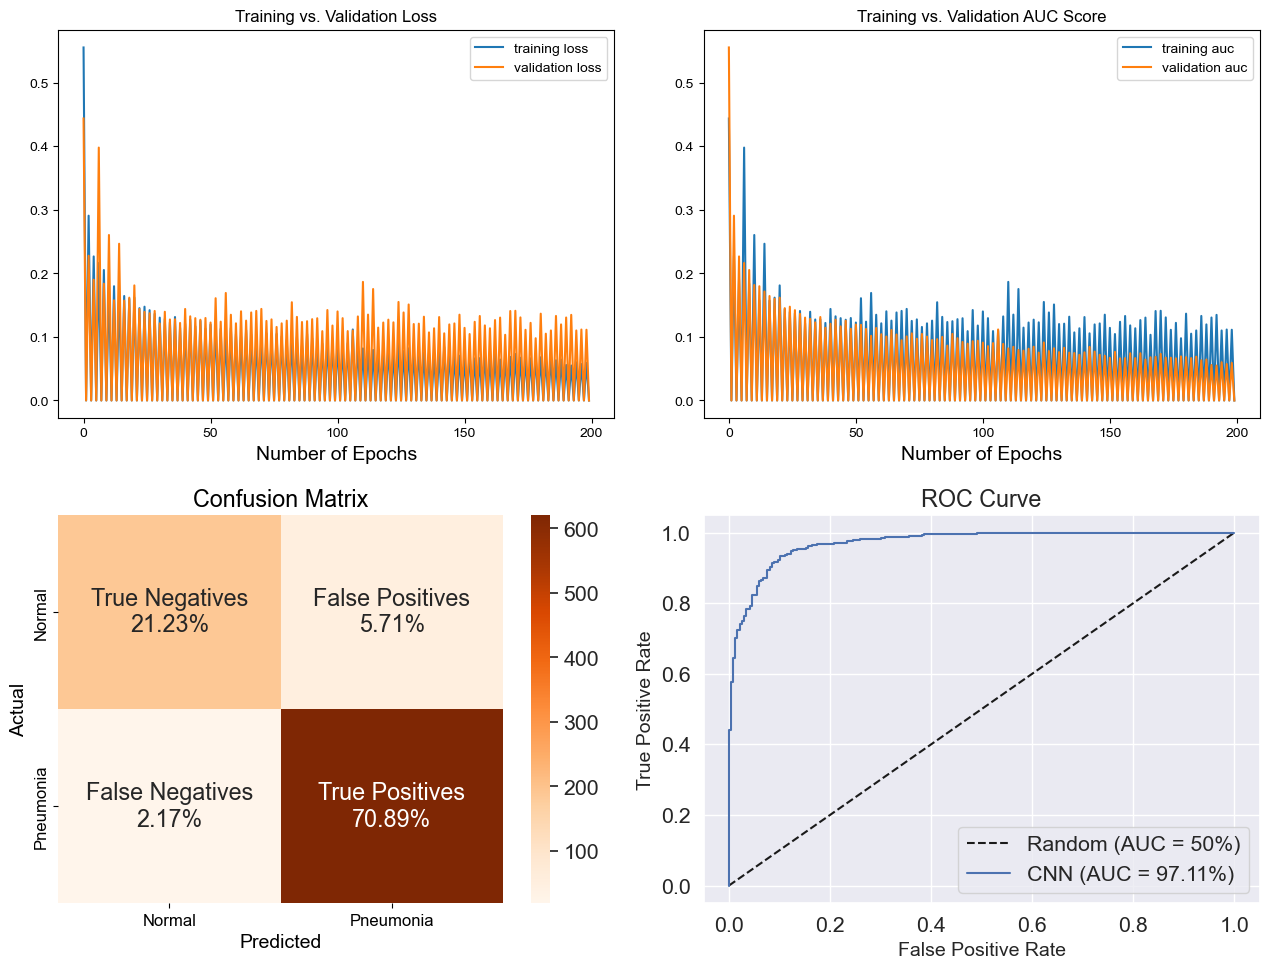

In [8]:
create_charts(cnn, cnn_model)

In [10]:
#Model 7(c): Conv2D x 3 + 128 dense units + (batch_size = 64) + (kernel = 5) (400 epochs)
hyper_feature_maps = 64
cnn = Sequential()
cnn.add(InputLayer(shape=(hyper_dimension, hyper_dimension, hyper_channels)))

cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=5, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=5, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=5, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())

cnn.add(Dense(activation='relu', units=128))
cnn.add(Dense(activation='sigmoid', units=1))

cnn.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=[AUC()])
cnn_model = cnn.fit(train_generator, 
                              steps_per_epoch = len(train_generator), 
                              epochs =400, 
                              validation_data = val_generator,
                              validation_steps = len(val_generator), 
                              verbose=2)

Epoch 1/400
129/129 - 27s - 209ms/step - auc_2: 0.7542 - loss: 0.4897 - val_auc_2: 0.9294 - val_loss: 0.4500
Epoch 2/400
129/129 - 0s - 106us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/400


2024-03-31 18:57:54.684690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/freazx/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-03-31 18:57:54.688223: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 26s - 205ms/step - auc_2: 0.9310 - loss: 0.2939 - val_auc_2: 0.9584 - val_loss: 0.3325
Epoch 4/400
129/129 - 0s - 60us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/400


2024-03-31 18:58:21.170698: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:58:21.173150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 32s - 245ms/step - auc_2: 0.9446 - loss: 0.2638 - val_auc_2: 0.9642 - val_loss: 0.2404
Epoch 6/400
129/129 - 0s - 103us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/400


2024-03-31 18:58:52.789280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:58:52.796071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 34s - 265ms/step - auc_2: 0.9494 - loss: 0.2528 - val_auc_2: 0.9637 - val_loss: 0.2393
Epoch 8/400
129/129 - 0s - 184us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/400


2024-03-31 18:59:26.997442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:59:27.008302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 33s - 254ms/step - auc_2: 0.9567 - loss: 0.2316 - val_auc_2: 0.9723 - val_loss: 0.2333
Epoch 10/400
129/129 - 0s - 120us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 11/400


2024-03-31 18:59:59.826248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 18:59:59.835203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 226ms/step - auc_2: 0.9669 - loss: 0.2074 - val_auc_2: 0.9739 - val_loss: 0.2943
Epoch 12/400
129/129 - 0s - 63us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 13/400


2024-03-31 19:00:29.063254: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:00:29.066171: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 229ms/step - auc_2: 0.9655 - loss: 0.2099 - val_auc_2: 0.9787 - val_loss: 0.1738
Epoch 14/400
129/129 - 0s - 73us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 15/400


2024-03-31 19:00:58.608487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:00:58.611898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 35s - 269ms/step - auc_2: 0.9682 - loss: 0.1989 - val_auc_2: 0.9790 - val_loss: 0.2049
Epoch 16/400
129/129 - 0s - 127us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 17/400


2024-03-31 19:01:33.274662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:01:33.284417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 226ms/step - auc_2: 0.9723 - loss: 0.1891 - val_auc_2: 0.9785 - val_loss: 0.1904
Epoch 18/400
129/129 - 0s - 66us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 19/400


2024-03-31 19:02:02.508585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:02:02.511405: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 232ms/step - auc_2: 0.9718 - loss: 0.1861 - val_auc_2: 0.9787 - val_loss: 0.1937
Epoch 20/400
129/129 - 0s - 59us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 21/400


2024-03-31 19:02:32.425842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:02:32.428598: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 224ms/step - auc_2: 0.9786 - loss: 0.1676 - val_auc_2: 0.9823 - val_loss: 0.1659
Epoch 22/400
129/129 - 0s - 71us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 23/400


2024-03-31 19:03:01.281964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:03:01.285263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 239ms/step - auc_2: 0.9749 - loss: 0.1791 - val_auc_2: 0.9782 - val_loss: 0.1913
Epoch 24/400
129/129 - 0s - 63us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 25/400


2024-03-31 19:03:32.095884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:03:32.098606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 32s - 248ms/step - auc_2: 0.9770 - loss: 0.1684 - val_auc_2: 0.9757 - val_loss: 0.1934
Epoch 26/400
129/129 - 0s - 66us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 27/400


2024-03-31 19:04:04.034965: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:04:04.037981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 33s - 259ms/step - auc_2: 0.9800 - loss: 0.1563 - val_auc_2: 0.9772 - val_loss: 0.1852
Epoch 28/400
129/129 - 0s - 72us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 29/400


2024-03-31 19:04:37.393785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:04:37.396695: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 240ms/step - auc_2: 0.9800 - loss: 0.1591 - val_auc_2: 0.9832 - val_loss: 0.1975
Epoch 30/400
129/129 - 0s - 63us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 31/400


2024-03-31 19:05:08.335737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:05:08.338686: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 242ms/step - auc_2: 0.9786 - loss: 0.1602 - val_auc_2: 0.9857 - val_loss: 0.1769
Epoch 32/400
129/129 - 0s - 55us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 33/400


2024-03-31 19:05:39.528432: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:05:39.531110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 32s - 245ms/step - auc_2: 0.9821 - loss: 0.1494 - val_auc_2: 0.9806 - val_loss: 0.2901
Epoch 34/400
129/129 - 0s - 67us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 35/400


2024-03-31 19:06:11.152600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:06:11.155421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 229ms/step - auc_2: 0.9793 - loss: 0.1592 - val_auc_2: 0.9846 - val_loss: 0.1998
Epoch 36/400
129/129 - 0s - 63us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 37/400


2024-03-31 19:06:40.724845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:06:40.727690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 222ms/step - auc_2: 0.9804 - loss: 0.1570 - val_auc_2: 0.9878 - val_loss: 0.1300
Epoch 38/400
129/129 - 0s - 64us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 39/400


2024-03-31 19:07:09.353236: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:07:09.356134: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 233ms/step - auc_2: 0.9835 - loss: 0.1421 - val_auc_2: 0.9833 - val_loss: 0.1443
Epoch 40/400
129/129 - 0s - 65us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 41/400


2024-03-31 19:07:39.401446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:07:39.405113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 235ms/step - auc_2: 0.9837 - loss: 0.1427 - val_auc_2: 0.9806 - val_loss: 0.1518
Epoch 42/400
129/129 - 0s - 54us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 43/400


2024-03-31 19:08:09.671600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:08:09.674116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 229ms/step - auc_2: 0.9834 - loss: 0.1461 - val_auc_2: 0.9874 - val_loss: 0.1504
Epoch 44/400
129/129 - 0s - 57us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 45/400


2024-03-31 19:08:39.171167: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:08:39.173857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 238ms/step - auc_2: 0.9831 - loss: 0.1446 - val_auc_2: 0.9908 - val_loss: 0.1564
Epoch 46/400
129/129 - 0s - 54us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 47/400


2024-03-31 19:09:09.823287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:09:09.825738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 231ms/step - auc_2: 0.9860 - loss: 0.1311 - val_auc_2: 0.9879 - val_loss: 0.1194
Epoch 48/400
129/129 - 0s - 58us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 49/400


2024-03-31 19:09:39.634945: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:09:39.637745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 231ms/step - auc_2: 0.9840 - loss: 0.1377 - val_auc_2: 0.9859 - val_loss: 0.1319
Epoch 50/400
129/129 - 0s - 58us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 51/400


2024-03-31 19:10:09.479269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:10:09.481824: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 228ms/step - auc_2: 0.9826 - loss: 0.1491 - val_auc_2: 0.9838 - val_loss: 0.1545
Epoch 52/400
129/129 - 0s - 62us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 53/400


2024-03-31 19:10:38.954432: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:10:38.957093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 28s - 216ms/step - auc_2: 0.9824 - loss: 0.1512 - val_auc_2: 0.9843 - val_loss: 0.1350
Epoch 54/400
129/129 - 0s - 59us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 55/400


2024-03-31 19:11:06.877657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:11:06.880289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 28s - 217ms/step - auc_2: 0.9863 - loss: 0.1284 - val_auc_2: 0.9870 - val_loss: 0.1280
Epoch 56/400
129/129 - 0s - 53us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 57/400


2024-03-31 19:11:34.822139: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:11:34.824608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 28s - 216ms/step - auc_2: 0.9873 - loss: 0.1242 - val_auc_2: 0.9891 - val_loss: 0.1661
Epoch 58/400
129/129 - 0s - 53us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 59/400


2024-03-31 19:12:02.644061: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:12:02.646589: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 28s - 215ms/step - auc_2: 0.9865 - loss: 0.1336 - val_auc_2: 0.9904 - val_loss: 0.1137
Epoch 60/400
129/129 - 0s - 54us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 61/400


2024-03-31 19:12:30.420338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:12:30.422904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 28s - 216ms/step - auc_2: 0.9873 - loss: 0.1273 - val_auc_2: 0.9876 - val_loss: 0.1316
Epoch 62/400
129/129 - 0s - 54us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 63/400


2024-03-31 19:12:58.321502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:12:58.323932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 28s - 216ms/step - auc_2: 0.9869 - loss: 0.1253 - val_auc_2: 0.9905 - val_loss: 0.1223
Epoch 64/400
129/129 - 0s - 53us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 65/400


2024-03-31 19:13:26.208249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:13:26.210667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 28s - 217ms/step - auc_2: 0.9862 - loss: 0.1257 - val_auc_2: 0.9895 - val_loss: 0.1913
Epoch 66/400
129/129 - 0s - 55us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 67/400


2024-03-31 19:13:54.224988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:13:54.227573: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 28s - 215ms/step - auc_2: 0.9866 - loss: 0.1269 - val_auc_2: 0.9890 - val_loss: 0.1189
Epoch 68/400
129/129 - 0s - 55us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 69/400


2024-03-31 19:14:21.914360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:14:21.916905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 28s - 217ms/step - auc_2: 0.9902 - loss: 0.1132 - val_auc_2: 0.9879 - val_loss: 0.1263
Epoch 70/400
129/129 - 0s - 63us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 71/400


2024-03-31 19:14:49.882774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:14:49.885902: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 28s - 216ms/step - auc_2: 0.9884 - loss: 0.1181 - val_auc_2: 0.9863 - val_loss: 0.1259
Epoch 72/400
129/129 - 0s - 52us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 73/400


2024-03-31 19:15:17.749691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:15:17.752097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 28s - 219ms/step - auc_2: 0.9879 - loss: 0.1212 - val_auc_2: 0.9880 - val_loss: 0.1191
Epoch 74/400
129/129 - 0s - 56us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 75/400


2024-03-31 19:15:45.970410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:15:45.972968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 28s - 217ms/step - auc_2: 0.9879 - loss: 0.1173 - val_auc_2: 0.9897 - val_loss: 0.1210
Epoch 76/400
129/129 - 0s - 53us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 77/400


2024-03-31 19:16:13.997890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:16:14.000287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 28s - 220ms/step - auc_2: 0.9867 - loss: 0.1272 - val_auc_2: 0.9869 - val_loss: 0.1314
Epoch 78/400
129/129 - 0s - 59us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 79/400


2024-03-31 19:16:42.334199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:16:42.336928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 28s - 220ms/step - auc_2: 0.9904 - loss: 0.1098 - val_auc_2: 0.9901 - val_loss: 0.1110
Epoch 80/400
129/129 - 0s - 54us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 81/400


2024-03-31 19:17:10.766352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:17:10.768920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 223ms/step - auc_2: 0.9896 - loss: 0.1164 - val_auc_2: 0.9900 - val_loss: 0.1149
Epoch 82/400
129/129 - 0s - 56us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 83/400


2024-03-31 19:17:39.539341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:17:39.541762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 28s - 220ms/step - auc_2: 0.9898 - loss: 0.1088 - val_auc_2: 0.9871 - val_loss: 0.1273
Epoch 84/400
129/129 - 0s - 53us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 85/400


2024-03-31 19:18:07.868687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:18:07.871252: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 28s - 221ms/step - auc_2: 0.9894 - loss: 0.1137 - val_auc_2: 0.9890 - val_loss: 0.1146
Epoch 86/400
129/129 - 0s - 57us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 87/400


2024-03-31 19:18:36.331311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:18:36.333924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 28s - 220ms/step - auc_2: 0.9866 - loss: 0.1194 - val_auc_2: 0.9886 - val_loss: 0.1592
Epoch 88/400
129/129 - 0s - 52us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 89/400


2024-03-31 19:19:04.729793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:19:04.732211: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 28s - 220ms/step - auc_2: 0.9916 - loss: 0.1008 - val_auc_2: 0.9876 - val_loss: 0.1161
Epoch 90/400
129/129 - 0s - 57us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 91/400


2024-03-31 19:19:33.123428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:19:33.126002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 28s - 221ms/step - auc_2: 0.9921 - loss: 0.1011 - val_auc_2: 0.9877 - val_loss: 0.1223
Epoch 92/400
129/129 - 0s - 52us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 93/400


2024-03-31 19:20:01.630621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:20:01.633040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 28s - 220ms/step - auc_2: 0.9914 - loss: 0.1015 - val_auc_2: 0.9872 - val_loss: 0.1705
Epoch 94/400
129/129 - 0s - 55us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 95/400


2024-03-31 19:20:30.066648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:20:30.069044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 221ms/step - auc_2: 0.9924 - loss: 0.0990 - val_auc_2: 0.9881 - val_loss: 0.1167
Epoch 96/400
129/129 - 0s - 53us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 97/400


2024-03-31 19:20:58.646955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:20:58.649371: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 28s - 220ms/step - auc_2: 0.9901 - loss: 0.1080 - val_auc_2: 0.9843 - val_loss: 0.1313
Epoch 98/400
129/129 - 0s - 56us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 99/400


2024-03-31 19:21:26.995982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:21:26.998453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 28s - 221ms/step - auc_2: 0.9909 - loss: 0.1043 - val_auc_2: 0.9885 - val_loss: 0.1304
Epoch 100/400
129/129 - 0s - 53us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 101/400


2024-03-31 19:21:55.454960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:21:55.457432: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 28s - 219ms/step - auc_2: 0.9902 - loss: 0.1035 - val_auc_2: 0.9872 - val_loss: 0.1322
Epoch 102/400
129/129 - 0s - 54us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 103/400


2024-03-31 19:22:23.725780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:22:23.728396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 28s - 221ms/step - auc_2: 0.9912 - loss: 0.1029 - val_auc_2: 0.9878 - val_loss: 0.1400
Epoch 104/400
129/129 - 0s - 52us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 105/400


2024-03-31 19:22:52.222903: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:22:52.225170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 28s - 221ms/step - auc_2: 0.9934 - loss: 0.0925 - val_auc_2: 0.9871 - val_loss: 0.1380
Epoch 106/400
129/129 - 0s - 53us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 107/400


2024-03-31 19:23:20.683232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:23:20.685706: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 28s - 220ms/step - auc_2: 0.9908 - loss: 0.0982 - val_auc_2: 0.9873 - val_loss: 0.1217
Epoch 108/400
129/129 - 0s - 58us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 109/400


2024-03-31 19:23:49.077984: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:23:49.080580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 28s - 220ms/step - auc_2: 0.9903 - loss: 0.1041 - val_auc_2: 0.9894 - val_loss: 0.1122
Epoch 110/400
129/129 - 0s - 54us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 111/400


2024-03-31 19:24:17.458697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:24:17.461272: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 222ms/step - auc_2: 0.9917 - loss: 0.0981 - val_auc_2: 0.9859 - val_loss: 0.1359
Epoch 112/400
129/129 - 0s - 55us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 113/400


2024-03-31 19:24:46.105466: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:24:46.107975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 28s - 221ms/step - auc_2: 0.9921 - loss: 0.0980 - val_auc_2: 0.9878 - val_loss: 0.1223
Epoch 114/400
129/129 - 0s - 61us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 115/400


2024-03-31 19:25:14.564959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:25:14.567670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 223ms/step - auc_2: 0.9937 - loss: 0.0857 - val_auc_2: 0.9866 - val_loss: 0.1378
Epoch 116/400
129/129 - 0s - 54us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 117/400


2024-03-31 19:25:43.404925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:25:43.407356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 221ms/step - auc_2: 0.9923 - loss: 0.0954 - val_auc_2: 0.9915 - val_loss: 0.1126
Epoch 118/400
129/129 - 0s - 54us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 119/400


2024-03-31 19:26:11.936625: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:26:11.939089: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 221ms/step - auc_2: 0.9931 - loss: 0.0875 - val_auc_2: 0.9903 - val_loss: 0.1102
Epoch 120/400
129/129 - 0s - 61us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 121/400


2024-03-31 19:26:40.469243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:26:40.472012: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 28s - 220ms/step - auc_2: 0.9921 - loss: 0.0950 - val_auc_2: 0.9890 - val_loss: 0.1100
Epoch 122/400
129/129 - 0s - 54us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 123/400


2024-03-31 19:27:08.826794: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:27:08.829306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 221ms/step - auc_2: 0.9933 - loss: 0.0898 - val_auc_2: 0.9898 - val_loss: 0.1119
Epoch 124/400
129/129 - 0s - 55us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 125/400


2024-03-31 19:27:37.350298: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:27:37.352787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 28s - 221ms/step - auc_2: 0.9927 - loss: 0.0935 - val_auc_2: 0.9886 - val_loss: 0.1208
Epoch 126/400
129/129 - 0s - 56us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 127/400


2024-03-31 19:28:05.821751: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:28:05.824500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 28s - 221ms/step - auc_2: 0.9917 - loss: 0.0942 - val_auc_2: 0.9880 - val_loss: 0.1285
Epoch 128/400
129/129 - 0s - 57us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 129/400


2024-03-31 19:28:34.329935: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:28:34.332491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 221ms/step - auc_2: 0.9938 - loss: 0.0828 - val_auc_2: 0.9900 - val_loss: 0.1603
Epoch 130/400
129/129 - 0s - 57us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 131/400


2024-03-31 19:29:02.851677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:29:02.854565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 28s - 221ms/step - auc_2: 0.9922 - loss: 0.0930 - val_auc_2: 0.9899 - val_loss: 0.1320
Epoch 132/400
129/129 - 0s - 55us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 133/400


2024-03-31 19:29:31.314422: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:29:31.317175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 28s - 220ms/step - auc_2: 0.9941 - loss: 0.0872 - val_auc_2: 0.9891 - val_loss: 0.1326
Epoch 134/400
129/129 - 0s - 56us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 135/400


2024-03-31 19:29:59.751263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:29:59.753903: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 221ms/step - auc_2: 0.9941 - loss: 0.0828 - val_auc_2: 0.9854 - val_loss: 0.1345
Epoch 136/400
129/129 - 0s - 54us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 137/400


2024-03-31 19:30:28.293624: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:30:28.296162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 28s - 221ms/step - auc_2: 0.9907 - loss: 0.1028 - val_auc_2: 0.9887 - val_loss: 0.1220
Epoch 138/400
129/129 - 0s - 61us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 139/400


2024-03-31 19:30:56.801411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:30:56.804159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 222ms/step - auc_2: 0.9918 - loss: 0.0976 - val_auc_2: 0.9879 - val_loss: 0.1271
Epoch 140/400
129/129 - 0s - 54us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 141/400


2024-03-31 19:31:25.387047: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:31:25.389671: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 222ms/step - auc_2: 0.9937 - loss: 0.0816 - val_auc_2: 0.9860 - val_loss: 0.1258
Epoch 142/400
129/129 - 0s - 53us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 143/400


2024-03-31 19:31:54.014959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:31:54.017452: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 222ms/step - auc_2: 0.9945 - loss: 0.0825 - val_auc_2: 0.9896 - val_loss: 0.1302
Epoch 144/400
129/129 - 0s - 53us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 145/400


2024-03-31 19:32:22.675356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:32:22.677776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 28s - 220ms/step - auc_2: 0.9936 - loss: 0.0857 - val_auc_2: 0.9873 - val_loss: 0.1434
Epoch 146/400
129/129 - 0s - 53us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 147/400


2024-03-31 19:32:51.090373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:32:51.092824: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 28s - 220ms/step - auc_2: 0.9939 - loss: 0.0847 - val_auc_2: 0.9856 - val_loss: 0.1381
Epoch 148/400
129/129 - 0s - 59us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 149/400


2024-03-31 19:33:19.524500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:33:19.527123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 221ms/step - auc_2: 0.9946 - loss: 0.0821 - val_auc_2: 0.9862 - val_loss: 0.1236
Epoch 150/400
129/129 - 0s - 58us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 151/400


2024-03-31 19:33:48.087529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:33:48.089902: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 222ms/step - auc_2: 0.9941 - loss: 0.0865 - val_auc_2: 0.9855 - val_loss: 0.1673
Epoch 152/400
129/129 - 0s - 57us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 153/400


2024-03-31 19:34:16.726695: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:34:16.729327: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 222ms/step - auc_2: 0.9949 - loss: 0.0768 - val_auc_2: 0.9802 - val_loss: 0.1608
Epoch 154/400
129/129 - 0s - 53us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 155/400


2024-03-31 19:34:45.366987: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:34:45.369466: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 221ms/step - auc_2: 0.9937 - loss: 0.0844 - val_auc_2: 0.9875 - val_loss: 0.1257
Epoch 156/400
129/129 - 0s - 56us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 157/400


2024-03-31 19:35:13.882356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:35:13.884972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 224ms/step - auc_2: 0.9937 - loss: 0.0868 - val_auc_2: 0.9872 - val_loss: 0.1172
Epoch 158/400
129/129 - 0s - 55us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 159/400


2024-03-31 19:35:42.820002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:35:42.822564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 222ms/step - auc_2: 0.9944 - loss: 0.0778 - val_auc_2: 0.9848 - val_loss: 0.1260
Epoch 160/400
129/129 - 0s - 53us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 161/400


2024-03-31 19:36:11.464317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:36:11.466801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 222ms/step - auc_2: 0.9936 - loss: 0.0814 - val_auc_2: 0.9857 - val_loss: 0.1264
Epoch 162/400
129/129 - 0s - 54us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 163/400


2024-03-31 19:36:40.102918: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:36:40.105466: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 32s - 245ms/step - auc_2: 0.9925 - loss: 0.0930 - val_auc_2: 0.9844 - val_loss: 0.1262
Epoch 164/400
129/129 - 0s - 60us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 165/400


2024-03-31 19:37:11.739092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:37:11.741872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 33s - 256ms/step - auc_2: 0.9943 - loss: 0.0780 - val_auc_2: 0.9884 - val_loss: 0.1934
Epoch 166/400
129/129 - 0s - 67us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 167/400


2024-03-31 19:37:44.781152: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:37:44.784361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 32s - 248ms/step - auc_2: 0.9930 - loss: 0.0911 - val_auc_2: 0.9858 - val_loss: 0.1480
Epoch 168/400
129/129 - 0s - 72us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 169/400


2024-03-31 19:38:16.830140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:38:16.833810: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 32s - 250ms/step - auc_2: 0.9946 - loss: 0.0817 - val_auc_2: 0.9851 - val_loss: 0.1291
Epoch 170/400
129/129 - 0s - 59us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 171/400


2024-03-31 19:38:49.124192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:38:49.126863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 33s - 257ms/step - auc_2: 0.9932 - loss: 0.0825 - val_auc_2: 0.9879 - val_loss: 0.1257
Epoch 172/400
129/129 - 0s - 65us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 173/400


2024-03-31 19:39:22.278565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:39:22.281544: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 33s - 253ms/step - auc_2: 0.9923 - loss: 0.0882 - val_auc_2: 0.9878 - val_loss: 0.1349
Epoch 174/400
129/129 - 0s - 63us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 175/400


2024-03-31 19:39:54.959476: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:39:54.962056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 33s - 255ms/step - auc_2: 0.9940 - loss: 0.0806 - val_auc_2: 0.9845 - val_loss: 0.1520
Epoch 176/400
129/129 - 0s - 62us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 177/400


2024-03-31 19:40:27.908821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:40:27.911608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 32s - 250ms/step - auc_2: 0.9950 - loss: 0.0685 - val_auc_2: 0.9859 - val_loss: 0.1551
Epoch 178/400
129/129 - 0s - 71us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 179/400


2024-03-31 19:41:00.131823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:41:00.135351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 243ms/step - auc_2: 0.9941 - loss: 0.0718 - val_auc_2: 0.9885 - val_loss: 0.1564
Epoch 180/400
129/129 - 0s - 60us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 181/400


2024-03-31 19:41:31.455858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:41:31.458643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 238ms/step - auc_2: 0.9944 - loss: 0.0805 - val_auc_2: 0.9855 - val_loss: 0.1457
Epoch 182/400
129/129 - 0s - 54us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 183/400


2024-03-31 19:42:02.173412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:42:02.175801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 34s - 264ms/step - auc_2: 0.9950 - loss: 0.0754 - val_auc_2: 0.9884 - val_loss: 0.1218
Epoch 184/400
129/129 - 0s - 78us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 185/400


2024-03-31 19:42:36.236911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:42:36.240318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 33s - 256ms/step - auc_2: 0.9945 - loss: 0.0800 - val_auc_2: 0.9892 - val_loss: 0.1176
Epoch 186/400
129/129 - 0s - 70us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 187/400


2024-03-31 19:43:09.233032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:43:09.236398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 32s - 250ms/step - auc_2: 0.9946 - loss: 0.0798 - val_auc_2: 0.9757 - val_loss: 0.1483
Epoch 188/400
129/129 - 0s - 93us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 189/400


2024-03-31 19:43:41.512202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:43:41.516718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 33s - 252ms/step - auc_2: 0.9958 - loss: 0.0713 - val_auc_2: 0.9857 - val_loss: 0.1237
Epoch 190/400
129/129 - 0s - 60us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 191/400


2024-03-31 19:44:14.034664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:44:14.037412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 237ms/step - auc_2: 0.9946 - loss: 0.0793 - val_auc_2: 0.9808 - val_loss: 0.1530
Epoch 192/400
129/129 - 0s - 57us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 193/400


2024-03-31 19:44:44.623972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:44:44.626546: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 32s - 245ms/step - auc_2: 0.9960 - loss: 0.0674 - val_auc_2: 0.9822 - val_loss: 0.1452
Epoch 194/400
129/129 - 0s - 60us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 195/400


2024-03-31 19:45:16.279373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:45:16.281912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 32s - 252ms/step - auc_2: 0.9957 - loss: 0.0740 - val_auc_2: 0.9792 - val_loss: 0.1934
Epoch 196/400
129/129 - 0s - 65us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 197/400


2024-03-31 19:45:48.744137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:45:48.747082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 243ms/step - auc_2: 0.9954 - loss: 0.0743 - val_auc_2: 0.9810 - val_loss: 0.1573
Epoch 198/400
129/129 - 0s - 65us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 199/400


2024-03-31 19:46:20.146876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:46:20.150083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 32s - 244ms/step - auc_2: 0.9962 - loss: 0.0573 - val_auc_2: 0.9868 - val_loss: 0.1668
Epoch 200/400
129/129 - 0s - 54us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 201/400


2024-03-31 19:46:51.685389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:46:51.687847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 232ms/step - auc_2: 0.9958 - loss: 0.0718 - val_auc_2: 0.9846 - val_loss: 0.1200
Epoch 202/400
129/129 - 0s - 66us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 203/400


2024-03-31 19:47:21.645029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:47:21.648125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 32s - 251ms/step - auc_2: 0.9951 - loss: 0.0731 - val_auc_2: 0.9817 - val_loss: 0.1493
Epoch 204/400
129/129 - 0s - 60us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 205/400


2024-03-31 19:47:53.981326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:47:53.984156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 231ms/step - auc_2: 0.9959 - loss: 0.0637 - val_auc_2: 0.9831 - val_loss: 0.1432
Epoch 206/400
129/129 - 0s - 57us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 207/400


2024-03-31 19:48:23.784305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:48:23.786839: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 233ms/step - auc_2: 0.9964 - loss: 0.0631 - val_auc_2: 0.9841 - val_loss: 0.1383
Epoch 208/400
129/129 - 0s - 57us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 209/400


2024-03-31 19:48:53.856703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:48:53.859196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 233ms/step - auc_2: 0.9958 - loss: 0.0642 - val_auc_2: 0.9848 - val_loss: 0.1408
Epoch 210/400
129/129 - 0s - 57us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 211/400


2024-03-31 19:49:23.937822: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:49:23.940425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 238ms/step - auc_2: 0.9956 - loss: 0.0678 - val_auc_2: 0.9821 - val_loss: 0.1300
Epoch 212/400
129/129 - 0s - 57us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 213/400


2024-03-31 19:49:54.674703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:49:54.677434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 32s - 248ms/step - auc_2: 0.9958 - loss: 0.0649 - val_auc_2: 0.9837 - val_loss: 0.1420
Epoch 214/400
129/129 - 0s - 77us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 215/400


2024-03-31 19:50:26.634946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:50:26.638379: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 233ms/step - auc_2: 0.9963 - loss: 0.0672 - val_auc_2: 0.9855 - val_loss: 0.1342
Epoch 216/400
129/129 - 0s - 62us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 217/400


2024-03-31 19:50:56.756267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:50:56.759014: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 235ms/step - auc_2: 0.9964 - loss: 0.0633 - val_auc_2: 0.9812 - val_loss: 0.1447
Epoch 218/400
129/129 - 0s - 61us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 219/400


2024-03-31 19:51:27.091721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:51:27.094721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 33s - 256ms/step - auc_2: 0.9966 - loss: 0.0663 - val_auc_2: 0.9817 - val_loss: 0.1596
Epoch 220/400
129/129 - 0s - 94us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 221/400


2024-03-31 19:52:00.178420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:52:00.182242: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 33s - 255ms/step - auc_2: 0.9962 - loss: 0.0635 - val_auc_2: 0.9847 - val_loss: 0.1323
Epoch 222/400
129/129 - 0s - 74us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 223/400


2024-03-31 19:52:33.025091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:52:33.028529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 33s - 257ms/step - auc_2: 0.9957 - loss: 0.0662 - val_auc_2: 0.9842 - val_loss: 0.1390
Epoch 224/400
129/129 - 0s - 73us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 225/400


2024-03-31 19:53:06.162665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:53:06.166014: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 236ms/step - auc_2: 0.9963 - loss: 0.0657 - val_auc_2: 0.9790 - val_loss: 0.1386
Epoch 226/400
129/129 - 0s - 61us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 227/400


2024-03-31 19:53:36.638791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:53:36.641581: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 33s - 259ms/step - auc_2: 0.9960 - loss: 0.0672 - val_auc_2: 0.9851 - val_loss: 0.1344
Epoch 228/400
129/129 - 0s - 73us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 229/400


2024-03-31 19:54:10.029867: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:54:10.032981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 33s - 257ms/step - auc_2: 0.9967 - loss: 0.0600 - val_auc_2: 0.9677 - val_loss: 0.1822
Epoch 230/400
129/129 - 0s - 65us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 231/400


2024-03-31 19:54:43.211250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:54:43.214083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 241ms/step - auc_2: 0.9944 - loss: 0.0770 - val_auc_2: 0.9869 - val_loss: 0.1596
Epoch 232/400
129/129 - 0s - 59us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 233/400


2024-03-31 19:55:14.264114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:55:14.266777: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 241ms/step - auc_2: 0.9960 - loss: 0.0673 - val_auc_2: 0.9833 - val_loss: 0.1304
Epoch 234/400
129/129 - 0s - 59us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 235/400


2024-03-31 19:55:45.375805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:55:45.378485: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 239ms/step - auc_2: 0.9969 - loss: 0.0599 - val_auc_2: 0.9836 - val_loss: 0.1346
Epoch 236/400
129/129 - 0s - 62us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 237/400


2024-03-31 19:56:16.175635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:56:16.178426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 237ms/step - auc_2: 0.9968 - loss: 0.0613 - val_auc_2: 0.9878 - val_loss: 0.1296
Epoch 238/400
129/129 - 0s - 57us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 239/400


2024-03-31 19:56:46.738582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:56:46.741145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 238ms/step - auc_2: 0.9957 - loss: 0.0658 - val_auc_2: 0.9842 - val_loss: 0.1302
Epoch 240/400
129/129 - 0s - 81us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 241/400


2024-03-31 19:57:17.432614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:57:17.437664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 240ms/step - auc_2: 0.9967 - loss: 0.0596 - val_auc_2: 0.9884 - val_loss: 0.1148
Epoch 242/400
129/129 - 0s - 65us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 243/400


2024-03-31 19:57:48.431062: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:57:48.434167: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 33s - 255ms/step - auc_2: 0.9961 - loss: 0.0648 - val_auc_2: 0.9846 - val_loss: 0.1362
Epoch 244/400
129/129 - 0s - 81us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 245/400


2024-03-31 19:58:21.292040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:58:21.296363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 237ms/step - auc_2: 0.9973 - loss: 0.0553 - val_auc_2: 0.9782 - val_loss: 0.1588
Epoch 246/400
129/129 - 0s - 64us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 247/400


2024-03-31 19:58:51.818688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:58:51.821677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 235ms/step - auc_2: 0.9970 - loss: 0.0571 - val_auc_2: 0.9844 - val_loss: 0.1302
Epoch 248/400
129/129 - 0s - 58us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 249/400


2024-03-31 19:59:22.127621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:59:22.130226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 236ms/step - auc_2: 0.9973 - loss: 0.0583 - val_auc_2: 0.9831 - val_loss: 0.1562
Epoch 250/400
129/129 - 0s - 58us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 251/400


2024-03-31 19:59:52.571761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:59:52.574310: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 235ms/step - auc_2: 0.9962 - loss: 0.0581 - val_auc_2: 0.9814 - val_loss: 0.1545
Epoch 252/400
129/129 - 0s - 56us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 253/400


2024-03-31 20:00:22.918052: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:00:22.920555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 32s - 249ms/step - auc_2: 0.9968 - loss: 0.0584 - val_auc_2: 0.9880 - val_loss: 0.1338
Epoch 254/400
129/129 - 0s - 69us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 255/400


2024-03-31 20:00:55.002668: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:00:55.005884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 240ms/step - auc_2: 0.9966 - loss: 0.0578 - val_auc_2: 0.9860 - val_loss: 0.1794
Epoch 256/400
129/129 - 0s - 61us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 257/400


2024-03-31 20:01:26.029820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:01:26.032494: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 241ms/step - auc_2: 0.9966 - loss: 0.0602 - val_auc_2: 0.9842 - val_loss: 0.1858
Epoch 258/400
129/129 - 0s - 58us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 259/400


2024-03-31 20:01:57.115512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:01:57.118178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 236ms/step - auc_2: 0.9968 - loss: 0.0562 - val_auc_2: 0.9816 - val_loss: 0.1395
Epoch 260/400
129/129 - 0s - 59us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 261/400


2024-03-31 20:02:27.508813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:02:27.511559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 237ms/step - auc_2: 0.9956 - loss: 0.0651 - val_auc_2: 0.9892 - val_loss: 0.1306
Epoch 262/400
129/129 - 0s - 58us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 263/400


2024-03-31 20:02:58.120252: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:02:58.122732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 33s - 259ms/step - auc_2: 0.9977 - loss: 0.0543 - val_auc_2: 0.9827 - val_loss: 0.1338
Epoch 264/400
129/129 - 0s - 82us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 265/400


2024-03-31 20:03:31.574808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:03:31.578725: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 32s - 246ms/step - auc_2: 0.9965 - loss: 0.0588 - val_auc_2: 0.9823 - val_loss: 0.1340
Epoch 266/400
129/129 - 0s - 74us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 267/400


2024-03-31 20:04:03.334985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:04:03.338456: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 32s - 246ms/step - auc_2: 0.9968 - loss: 0.0556 - val_auc_2: 0.9831 - val_loss: 0.1285
Epoch 268/400
129/129 - 0s - 65us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 269/400


2024-03-31 20:04:35.138274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:04:35.141148: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 244ms/step - auc_2: 0.9980 - loss: 0.0506 - val_auc_2: 0.9789 - val_loss: 0.1543
Epoch 270/400
129/129 - 0s - 63us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 271/400


2024-03-31 20:05:06.567185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:05:06.570024: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 32s - 244ms/step - auc_2: 0.9960 - loss: 0.0593 - val_auc_2: 0.9876 - val_loss: 0.1371
Epoch 272/400
129/129 - 0s - 84us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 273/400


2024-03-31 20:05:38.096793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:05:38.100581: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 237ms/step - auc_2: 0.9976 - loss: 0.0540 - val_auc_2: 0.9871 - val_loss: 0.1281
Epoch 274/400
129/129 - 0s - 64us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 275/400


2024-03-31 20:06:08.672899: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:06:08.675864: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 32s - 250ms/step - auc_2: 0.9978 - loss: 0.0487 - val_auc_2: 0.9840 - val_loss: 0.1397
Epoch 276/400
129/129 - 0s - 298us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 277/400


2024-03-31 20:06:40.911576: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:06:40.919934: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 242ms/step - auc_2: 0.9973 - loss: 0.0491 - val_auc_2: 0.9853 - val_loss: 0.1474
Epoch 278/400
129/129 - 0s - 61us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 279/400


2024-03-31 20:07:12.179285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:07:12.182062: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 242ms/step - auc_2: 0.9981 - loss: 0.0473 - val_auc_2: 0.9698 - val_loss: 0.1803
Epoch 280/400
129/129 - 0s - 61us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 281/400


2024-03-31 20:07:43.394374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:07:43.397178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 33s - 259ms/step - auc_2: 0.9973 - loss: 0.0530 - val_auc_2: 0.9854 - val_loss: 0.1342
Epoch 282/400
129/129 - 0s - 81us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 283/400


2024-03-31 20:08:16.880598: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:08:16.884114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 241ms/step - auc_2: 0.9972 - loss: 0.0530 - val_auc_2: 0.9819 - val_loss: 0.1813
Epoch 284/400
129/129 - 0s - 75us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 285/400


2024-03-31 20:08:47.968948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:08:47.972181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 240ms/step - auc_2: 0.9978 - loss: 0.0488 - val_auc_2: 0.9857 - val_loss: 0.1458
Epoch 286/400
129/129 - 0s - 207us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 287/400


2024-03-31 20:09:18.986181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:09:18.998376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 243ms/step - auc_2: 0.9971 - loss: 0.0557 - val_auc_2: 0.9745 - val_loss: 0.1724
Epoch 288/400
129/129 - 0s - 94us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 289/400


2024-03-31 20:09:50.372026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:09:50.375691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 34s - 266ms/step - auc_2: 0.9970 - loss: 0.0539 - val_auc_2: 0.9841 - val_loss: 0.1414
Epoch 290/400
129/129 - 0s - 81us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 291/400


2024-03-31 20:10:24.686041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:10:24.689747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 32s - 247ms/step - auc_2: 0.9981 - loss: 0.0489 - val_auc_2: 0.9792 - val_loss: 0.1847
Epoch 292/400
129/129 - 0s - 70us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 293/400


2024-03-31 20:10:56.587283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:10:56.590285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 34s - 260ms/step - auc_2: 0.9970 - loss: 0.0564 - val_auc_2: 0.9817 - val_loss: 0.1754
Epoch 294/400
129/129 - 0s - 93us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 295/400


2024-03-31 20:11:30.191158: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:11:30.194949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 32s - 247ms/step - auc_2: 0.9964 - loss: 0.0601 - val_auc_2: 0.9779 - val_loss: 0.1529
Epoch 296/400
129/129 - 0s - 75us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 297/400


2024-03-31 20:12:02.020329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:12:02.023862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 32s - 250ms/step - auc_2: 0.9957 - loss: 0.0642 - val_auc_2: 0.9801 - val_loss: 0.1460
Epoch 298/400
129/129 - 0s - 85us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 299/400


2024-03-31 20:12:34.278973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:12:34.282544: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 32s - 250ms/step - auc_2: 0.9985 - loss: 0.0435 - val_auc_2: 0.9796 - val_loss: 0.1585
Epoch 300/400
129/129 - 0s - 64us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 301/400


2024-03-31 20:13:06.560401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:13:06.563274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 244ms/step - auc_2: 0.9980 - loss: 0.0481 - val_auc_2: 0.9712 - val_loss: 0.1697
Epoch 302/400
129/129 - 0s - 81us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 303/400


2024-03-31 20:13:38.067423: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:13:38.070872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 241ms/step - auc_2: 0.9977 - loss: 0.0446 - val_auc_2: 0.9738 - val_loss: 0.1721
Epoch 304/400
129/129 - 0s - 94us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 305/400


2024-03-31 20:14:09.133174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:14:09.138082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 236ms/step - auc_2: 0.9973 - loss: 0.0496 - val_auc_2: 0.9712 - val_loss: 0.2340
Epoch 306/400
129/129 - 0s - 60us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 307/400


2024-03-31 20:14:39.596360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:14:39.599026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 229ms/step - auc_2: 0.9983 - loss: 0.0459 - val_auc_2: 0.9847 - val_loss: 0.1453
Epoch 308/400
129/129 - 0s - 77us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 309/400


2024-03-31 20:15:09.160127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:15:09.163652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 237ms/step - auc_2: 0.9981 - loss: 0.0447 - val_auc_2: 0.9803 - val_loss: 0.1775
Epoch 310/400
129/129 - 0s - 62us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 311/400


2024-03-31 20:15:39.787885: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:15:39.790665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 32s - 244ms/step - auc_2: 0.9979 - loss: 0.0468 - val_auc_2: 0.9791 - val_loss: 0.1743
Epoch 312/400
129/129 - 0s - 94us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 313/400


2024-03-31 20:16:11.312897: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:16:11.316415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 233ms/step - auc_2: 0.9974 - loss: 0.0513 - val_auc_2: 0.9827 - val_loss: 0.1876
Epoch 314/400
129/129 - 0s - 59us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 315/400


2024-03-31 20:16:41.334335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:16:41.337043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 236ms/step - auc_2: 0.9979 - loss: 0.0459 - val_auc_2: 0.9854 - val_loss: 0.1584
Epoch 316/400
129/129 - 0s - 76us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 317/400


2024-03-31 20:17:11.804788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:17:11.808152: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 234ms/step - auc_2: 0.9987 - loss: 0.0410 - val_auc_2: 0.9791 - val_loss: 0.1587
Epoch 318/400
129/129 - 0s - 60us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 319/400


2024-03-31 20:17:41.952548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:17:41.955297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 233ms/step - auc_2: 0.9970 - loss: 0.0462 - val_auc_2: 0.9780 - val_loss: 0.1665
Epoch 320/400
129/129 - 0s - 79us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 321/400


2024-03-31 20:18:11.985152: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:18:11.988493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 237ms/step - auc_2: 0.9971 - loss: 0.0518 - val_auc_2: 0.9737 - val_loss: 0.1700
Epoch 322/400
129/129 - 0s - 61us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 323/400


2024-03-31 20:18:42.547481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:18:42.550373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 237ms/step - auc_2: 0.9966 - loss: 0.0452 - val_auc_2: 0.9833 - val_loss: 0.1602
Epoch 324/400
129/129 - 0s - 69us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 325/400


2024-03-31 20:19:13.107129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:19:13.110188: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 32s - 249ms/step - auc_2: 0.9985 - loss: 0.0422 - val_auc_2: 0.9788 - val_loss: 0.1699
Epoch 326/400
129/129 - 0s - 105us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 327/400


2024-03-31 20:19:45.230640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:19:45.234731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 239ms/step - auc_2: 0.9958 - loss: 0.0548 - val_auc_2: 0.9846 - val_loss: 0.1470
Epoch 328/400
129/129 - 0s - 80us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 329/400


2024-03-31 20:20:16.078888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:20:16.082371: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 237ms/step - auc_2: 0.9981 - loss: 0.0439 - val_auc_2: 0.9812 - val_loss: 0.1495
Epoch 330/400
129/129 - 0s - 64us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 331/400


2024-03-31 20:20:46.639711: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:20:46.642551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 243ms/step - auc_2: 0.9982 - loss: 0.0460 - val_auc_2: 0.9833 - val_loss: 0.1700
Epoch 332/400
129/129 - 0s - 106us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 333/400


2024-03-31 20:21:17.954645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:21:17.958648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 32s - 249ms/step - auc_2: 0.9983 - loss: 0.0448 - val_auc_2: 0.9839 - val_loss: 0.1817
Epoch 334/400
129/129 - 0s - 77us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 335/400


2024-03-31 20:21:50.127646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:21:50.131008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 32s - 251ms/step - auc_2: 0.9987 - loss: 0.0384 - val_auc_2: 0.9804 - val_loss: 0.1530
Epoch 336/400
129/129 - 0s - 104us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 337/400


2024-03-31 20:22:22.579368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:22:22.583450: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 240ms/step - auc_2: 0.9989 - loss: 0.0375 - val_auc_2: 0.9789 - val_loss: 0.1573
Epoch 338/400
129/129 - 0s - 63us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 339/400


2024-03-31 20:22:53.563870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:22:53.566715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 244ms/step - auc_2: 0.9977 - loss: 0.0427 - val_auc_2: 0.9712 - val_loss: 0.1818
Epoch 340/400
129/129 - 0s - 75us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 341/400


2024-03-31 20:23:25.007561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:23:25.011330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 34s - 265ms/step - auc_2: 0.9981 - loss: 0.0448 - val_auc_2: 0.9818 - val_loss: 0.1416
Epoch 342/400
129/129 - 0s - 126us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 343/400


2024-03-31 20:23:59.194664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:23:59.199208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 35s - 269ms/step - auc_2: 0.9974 - loss: 0.0547 - val_auc_2: 0.9836 - val_loss: 0.1878
Epoch 344/400
129/129 - 0s - 85us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 345/400


2024-03-31 20:24:33.939388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:24:33.943027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 241ms/step - auc_2: 0.9974 - loss: 0.0485 - val_auc_2: 0.9847 - val_loss: 0.2131
Epoch 346/400
129/129 - 0s - 86us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 347/400


2024-03-31 20:25:05.025536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:25:05.029701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 239ms/step - auc_2: 0.9986 - loss: 0.0395 - val_auc_2: 0.9804 - val_loss: 0.1488
Epoch 348/400
129/129 - 0s - 65us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 349/400


2024-03-31 20:25:35.807308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:25:35.810066: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 237ms/step - auc_2: 0.9972 - loss: 0.0438 - val_auc_2: 0.9783 - val_loss: 0.1556
Epoch 350/400
129/129 - 0s - 90us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 351/400


2024-03-31 20:26:06.414967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:26:06.418727: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 243ms/step - auc_2: 0.9986 - loss: 0.0355 - val_auc_2: 0.9827 - val_loss: 0.1610
Epoch 352/400
129/129 - 0s - 89us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 353/400


2024-03-31 20:26:37.749862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:26:37.753819: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 34s - 265ms/step - auc_2: 0.9987 - loss: 0.0410 - val_auc_2: 0.9870 - val_loss: 0.1318
Epoch 354/400
129/129 - 0s - 110us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 355/400


2024-03-31 20:27:11.970814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:27:11.975889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 34s - 263ms/step - auc_2: 0.9983 - loss: 0.0457 - val_auc_2: 0.9820 - val_loss: 0.1443
Epoch 356/400
129/129 - 0s - 63us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 357/400


2024-03-31 20:27:45.893374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:27:45.896309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 234ms/step - auc_2: 0.9985 - loss: 0.0420 - val_auc_2: 0.9724 - val_loss: 0.1845
Epoch 358/400
129/129 - 0s - 61us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 359/400


2024-03-31 20:28:16.140051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:28:16.142811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 236ms/step - auc_2: 0.9982 - loss: 0.0452 - val_auc_2: 0.9769 - val_loss: 0.1612
Epoch 360/400
129/129 - 0s - 59us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 361/400


2024-03-31 20:28:46.561847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:28:46.564479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 235ms/step - auc_2: 0.9988 - loss: 0.0393 - val_auc_2: 0.9788 - val_loss: 0.1594
Epoch 362/400
129/129 - 0s - 59us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 363/400


2024-03-31 20:29:16.889569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:29:16.892176: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 235ms/step - auc_2: 0.9980 - loss: 0.0435 - val_auc_2: 0.9831 - val_loss: 0.1594
Epoch 364/400
129/129 - 0s - 62us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 365/400


2024-03-31 20:29:47.197129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:29:47.200032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 233ms/step - auc_2: 0.9985 - loss: 0.0378 - val_auc_2: 0.9813 - val_loss: 0.1484
Epoch 366/400
129/129 - 0s - 59us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 367/400


2024-03-31 20:30:17.303816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:30:17.306343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 235ms/step - auc_2: 0.9984 - loss: 0.0454 - val_auc_2: 0.9744 - val_loss: 0.1731
Epoch 368/400
129/129 - 0s - 67us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 369/400


2024-03-31 20:30:47.601762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:30:47.605050: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 29s - 226ms/step - auc_2: 0.9984 - loss: 0.0400 - val_auc_2: 0.9804 - val_loss: 0.1358
Epoch 370/400
129/129 - 0s - 55us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 371/400


2024-03-31 20:31:16.767419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:31:16.769851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 231ms/step - auc_2: 0.9983 - loss: 0.0413 - val_auc_2: 0.9829 - val_loss: 0.2287
Epoch 372/400
129/129 - 0s - 62us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 373/400


2024-03-31 20:31:46.562012: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:31:46.564835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 231ms/step - auc_2: 0.9973 - loss: 0.0500 - val_auc_2: 0.9732 - val_loss: 0.2308
Epoch 374/400
129/129 - 0s - 70us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 375/400


2024-03-31 20:32:16.382638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:32:16.385748: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 233ms/step - auc_2: 0.9984 - loss: 0.0396 - val_auc_2: 0.9724 - val_loss: 0.1944
Epoch 376/400
129/129 - 0s - 57us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 377/400


2024-03-31 20:32:46.408202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:32:46.410799: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 231ms/step - auc_2: 0.9982 - loss: 0.0406 - val_auc_2: 0.9881 - val_loss: 0.1286
Epoch 378/400
129/129 - 0s - 61us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 379/400


2024-03-31 20:33:16.206122: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:33:16.208661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 231ms/step - auc_2: 0.9981 - loss: 0.0378 - val_auc_2: 0.9848 - val_loss: 0.1428
Epoch 380/400
129/129 - 0s - 89us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 381/400


2024-03-31 20:33:45.981462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:33:45.984724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 232ms/step - auc_2: 0.9990 - loss: 0.0329 - val_auc_2: 0.9789 - val_loss: 0.1672
Epoch 382/400
129/129 - 0s - 75us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 383/400


2024-03-31 20:34:15.969114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:34:15.971886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 231ms/step - auc_2: 0.9983 - loss: 0.0398 - val_auc_2: 0.9740 - val_loss: 0.1881
Epoch 384/400
129/129 - 0s - 62us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 385/400


2024-03-31 20:34:45.727530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:34:45.730411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 232ms/step - auc_2: 0.9978 - loss: 0.0360 - val_auc_2: 0.9841 - val_loss: 0.1454
Epoch 386/400
129/129 - 0s - 58us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 387/400


2024-03-31 20:35:15.643096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:35:15.645720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 230ms/step - auc_2: 0.9988 - loss: 0.0367 - val_auc_2: 0.9814 - val_loss: 0.1546
Epoch 388/400
129/129 - 0s - 76us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 389/400


2024-03-31 20:35:45.381376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:35:45.384548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 234ms/step - auc_2: 0.9993 - loss: 0.0316 - val_auc_2: 0.9771 - val_loss: 0.1754
Epoch 390/400
129/129 - 0s - 62us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 391/400


2024-03-31 20:36:15.570608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:36:15.573348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 233ms/step - auc_2: 0.9974 - loss: 0.0406 - val_auc_2: 0.9767 - val_loss: 0.1793
Epoch 392/400
129/129 - 0s - 67us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 393/400


2024-03-31 20:36:45.684694: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:36:45.687779: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 233ms/step - auc_2: 0.9981 - loss: 0.0366 - val_auc_2: 0.9845 - val_loss: 0.1740
Epoch 394/400
129/129 - 0s - 59us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 395/400


2024-03-31 20:37:15.735271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:37:15.737893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 234ms/step - auc_2: 0.9986 - loss: 0.0327 - val_auc_2: 0.9835 - val_loss: 0.1683
Epoch 396/400
129/129 - 0s - 60us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 397/400


2024-03-31 20:37:45.920865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:37:45.923505: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 30s - 234ms/step - auc_2: 0.9991 - loss: 0.0314 - val_auc_2: 0.9834 - val_loss: 0.1386
Epoch 398/400
129/129 - 0s - 72us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 399/400


2024-03-31 20:38:16.146963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:38:16.150064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 - 31s - 238ms/step - auc_2: 0.9986 - loss: 0.0354 - val_auc_2: 0.9828 - val_loss: 0.1432
Epoch 400/400
129/129 - 0s - 60us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00


2024-03-31 20:38:46.885765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 20:38:46.888440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step
[Summary Statistics]
Accuracy = 93.15% | Precision = 92.77% | Recall = 98.28% | Specificity = 79.24% | F1 Score = 95.45%


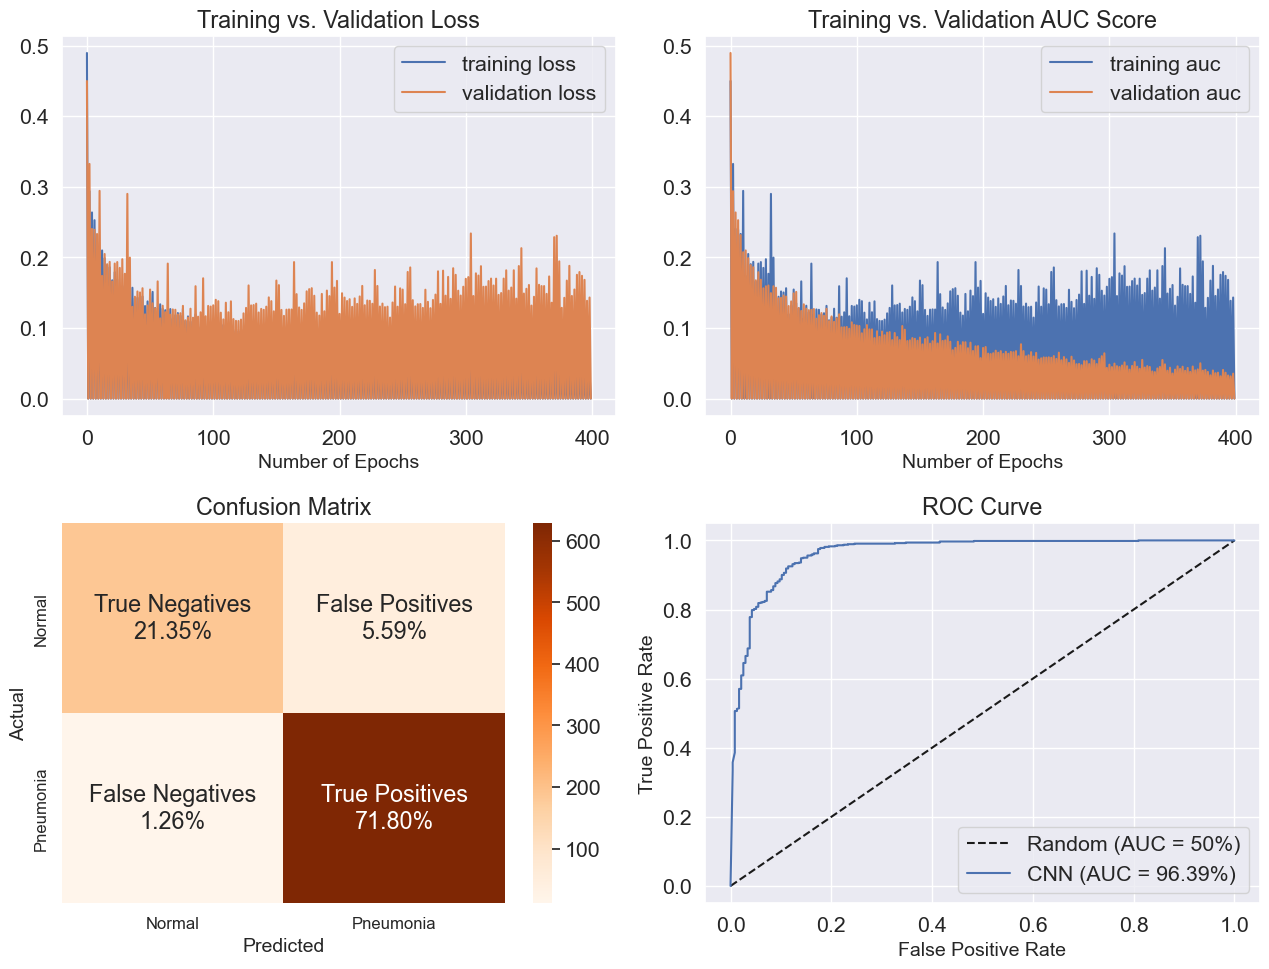

In [11]:
create_charts(cnn, cnn_model)